## Backbone Network
- ResNet 기반 특징 추출기 정의 (Backbone 클래스)
- FrozenBatchNorm2d 활용하여 ResNet의 BatchNorm을 고정 (FrozenBatchNorm2d 클래스)
- 트랜스포머 입력을 위해 백본과 위치 인코딩을 결합하는 구조 (Joiner 클래스)
- 백본을 구축하는 함수 (build_backbone)

In [ ]:
from typing import Dict, List

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.ops.feature_pyramid_network import (FeaturePyramidNetwork,
                                                     LastLevelMaxPool)

from ..util.misc import NestedTensor, is_main_process
from .position_encoding import build_position_encoding

`FrozenBatchNorm2d (BatchNorm 고정)`
- 일반적으로 CNN 백본(ResNet)에서 Batch Normalization은 미니배치마다 평균과 분산을 계산하여 정규화를 수행
- FrozenBatchNorm2d는 학습이 진행되지 않으며, 미리 학습된 값을 고정하여 사용
-  ResNet 백본을 사용할 때 미리 학습된 BatchNorm 값을 유지하고, 불필요한 학습을 방지

*일반적인 BatchNorm은 미니배치 크기에 따라 변동되지만, MOT(Multi-Object Tracking)에서는 미니배치 크기가 작아 통계가 불안정할 수 있음.*

*따라서 FrozenBatchNorm2d를 적용하여 BatchNorm의 평균과 분산을 고정하여 사용*

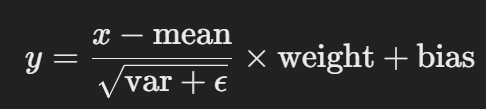

In [ ]:
class FrozenBatchNorm2d(torch.nn.Module):
    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))
    
    # n: feature map의 채널 수
    # register_buffer: state_dict에는 저장되지만, 학습 중에는 update되지 않는 tensor 등록
    # self.weight: scaling 계수(default 1)
    # self.bias: bias 계수(defalut 0)
    # self.running_mean: 고정된 평균값 (defalut 0)
    # self.running_var: 고정된 분산값 (defalut 1)
    # => BatchNorm의 가중치(weight)와 편향(bias) 값이 동결(frozen)되어 학습되지 않는다.

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    # 일반적인 BatchNorm2d는 num_batches_tracked라는 변수를 포함하여, 배치 통계를 추적
    # FrozenBatchNorm2d는 학습 도중 통계를 업데이트하지 않으므로 해당 변수를 삭제하여 state_dict 로드 시 오류를 방지
    # => 일반적인 BatchNorm과 다르게 num_batches_tracked 변수를 제거하여 동결된 상태를 유지

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias
    
    # reshape(1, -1, 1, 1): 배치 연산을 위해 [C] → [1, C, 1, 1] 형태로 변환하여 broadcasting이 가능하게 만든다.
    # eps = 1e-5: 수치 안정성(Numerical Stability)을 위해 작은 값을 추가하여 나누기 연산에서 NaN이 발생하는 것을 방지
    # scale = w * (rv + eps).rsqrt(): 정규화 스케일 계산
    # bias = b - rm * scale: 정규화 후 bias 조정, 미리 계산된 bias 적용
    # return x * scale + bias: 입력 x를 정규화한 후 weight와 bias를 적용하여 반환
    # => 입력 tensor를 미리 고정된 평균과 분산을 이용해 정규화하고, weight와 bias를 곱하여 변환

`Backbone`
- TrackFormer에서 CNN 백본(Backbone)을 설정하고 관리하는 역할
- 특정 레이어(layer1, layer2, layer3, layer4)의 출력을 반환할지 여부를 결정하며, 특정 레이어의 학습을 동결할지(trainable) 여부도 설정

In [ ]:
class BackboneBase(nn.Module):

    def __init__(self, backbone: nn.Module, train_backbone: bool,
                 return_interm_layers: bool):
        super().__init__()
        for name, parameter in backbone.named_parameters():
            if (not train_backbone
                or 'layer2' not in name
                and 'layer3' not in name
                and 'layer4' not in name):
                parameter.requires_grad_(False)
        
        # train_backbone = False: 모든 백본(ResNet) 레이어를 동결(Freeze)
        # train_backbone = True: layer2, layer3, layer4만 학습 가능하게 설정
        # => TrackFormer는 ResNet을 백본으로 일부만 학습 가능하도록 설정

        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
            # return_layers = {"layer2": "0", "layer3": "1", "layer4": "2"}
            self.strides = [4, 8, 16, 32]
            self.num_channels = [256, 512, 1024, 2048]
        else:
            return_layers = {'layer4': "0"}
            self.strides = [32]
            self.num_channels = [2048]
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)

        # 1. return_interm_layers = True
        # layer1, layer2, layer3, layer4의 출력 모두 반환
        # 다양한 해상도의 특징(feature map)을 활용 가능
        # 출력 stride → [4, 8, 16, 32] (해상도가 점진적으로 줄어듦)
        # 채널 수 [256, 512, 1024, 2048]

        # 2. return_interm_layers = False
        # layer4의 출력만 반환
        # 출력 stride = 32
        # 채널 수 [2048]
        # IntermediateLayerGetter: return_layers에 지정된 레이어의 출력만 가져와 반환하는 역할
        # ResNet의 중간 출력을 쉽게 가져와 트랜스포머 입력으로 활용

        # => return_interm_layers가 True이면 다중 해상도 특징 피라미드(FPN) 방식을 활용

    def forward(self, tensor_list: NestedTensor):
        xs = self.body(tensor_list.tensors)
        out: Dict[str, NestedTensor] = {}
        for name, x in xs.items():
            m = tensor_list.mask
            assert m is not None
            mask = F.interpolate(m[None].float(), size=x.shape[-2:]).to(torch.bool)[0]
            out[name] = NestedTensor(x, mask)
        return out

    # => CNN 백본을 통과한 후, 특징 맵과 마스크 정보를 결합하여 Transformer가 처리할 수 있도록 변환

class Backbone(BackboneBase):
    """ResNet backbone with frozen BatchNorm."""
    def __init__(self, name: str,
                 train_backbone: bool,
                 return_interm_layers: bool,
                 dilation: bool):
        norm_layer = FrozenBatchNorm2d
        backbone = getattr(torchvision.models, name)(
            replace_stride_with_dilation=[False, False, dilation],
            pretrained=is_main_process(), norm_layer=norm_layer)
        super().__init__(backbone, train_backbone,
                         return_interm_layers)
        if dilation:
            self.strides[-1] = self.strides[-1] // 2

    # => 사전 학습된 ResNet을 백본으로 사용하며, 특정 설정에 따라 stride나 dilation을 조정
    

`Joiner` 
- CNN 백본(ResNet)에서 추출한 feature map과 Position Encoding을 결합

In [ ]:
class Joiner(nn.Sequential):
    def __init__(self, backbone, position_embedding):
        super().__init__(backbone, position_embedding)
        self.strides = backbone.strides
        self.num_channels = backbone.num_channels

    def forward(self, tensor_list: NestedTensor):
        xs = self[0](tensor_list)
        out: List[NestedTensor] = []
        pos = []
        for x in xs.values():
            out.append(x)
            # position encoding
            pos.append(self[1](x).to(x.tensors.dtype))

        return out, pos

    # => CNN 백본에서 나온 특징을 Transformer가 사용할 수 있도록, 위치 정보를 추가하는 역할


`bulid_backbone`
- "CNN → Transformer 입력 변환" 과정을 구현

In [ ]:
def build_backbone(args):
    position_embedding = build_position_encoding(args)
    train_backbone = args.lr_backbone > 0
    return_interm_layers = args.masks or (args.num_feature_levels > 1)
    backbone = Backbone(args.backbone,
                        train_backbone,
                        return_interm_layers,
                        args.dilation)
    model = Joiner(backbone, position_embedding)
    return model

# => CNN을 이용해 특징을 추출한 후 Transformer 입력으로 변환하는 과정